In [19]:
#Importing all needed librarys
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pipetorch.train import *
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from tqdm import tqdm
from torch import nn, optim
import seaborn as sns
import torch.nn.functional as F

# importing the libraries
import pandas as pd
import numpy as np

# for creating validation set
from sklearn.model_selection import train_test_split


import torchvision
from torchvision.datasets import ImageFolder

In [20]:
#Checking wich GPU is beeing used

!nvidia-smi

Mon Nov 22 12:45:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 29%   27C    P8    17W / 250W |  10073MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 29%   

In [21]:
#Load data
data_file_true = 'dialogue/Dataset/VoiceDetection/Big_dataset/Output_true.npy'
data_file_false = 'dialogue/Dataset/VoiceDetection/Big_dataset/Output_false.npy'

true_data = np.load(data_file_true, allow_pickle = True)
false_data = np.load(data_file_false, allow_pickle = True)
df_true_data = pd.DataFrame(true_data)
df_false_data = pd.DataFrame(false_data)

df_true_data['label'] = True
df_false_data['label'] = False
#print(data)

#df_data['data'] = df_temp.values.tolist()
df_data = pd.concat([df_true_data, df_false_data])
#print(df_data.head())
np_labels = df_data['label'].to_numpy()
np_data = df_data.drop(['label'],axis = 1).to_numpy()
print(df_data)
print(np_labels)

                0           1           2           3           4           5  \
0     -602.022766 -602.723755 -603.376587 -604.697205 -604.944519 -604.832581   
1     -184.963791 -167.952698 -158.673050 -179.185837 -206.072037 -246.351532   
2     -273.273712 -253.240891 -222.000061 -167.081268 -170.382721 -216.621155   
3     -612.132263 -605.841003 -601.784912 -606.503540 -611.724365 -615.397827   
4      -99.539803 -116.719917 -150.092438 -132.454346 -153.093674 -134.829453   
...           ...         ...         ...         ...         ...         ...   
19995  -98.696381 -146.676620 -321.676208 -422.174591 -432.748322 -428.995758   
19996 -432.957977 -425.469818 -424.276611 -431.652863 -432.145569 -430.457733   
19997 -196.815552 -247.848114 -390.696655 -428.601593 -427.747406 -428.584503   
19998 -434.154480 -429.234955 -431.356506 -430.332977 -432.144257 -431.375946   
19999 -151.141281 -196.110397 -353.022400 -425.890198 -426.080780 -427.372894   

                6          

In [22]:
#df_data.drop(['isSpeaking'],axis = 1)
X_train, X_test, y_train, y_test = train_test_split(np_data, np_labels, test_size = 0.2, random_state = 23)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 23)
print(type(X_train))
#print(X_train)

<class 'numpy.ndarray'>


In [23]:
#print(pd.DataFrame(X_train))
X_train = torch.from_numpy(X_train).float()
X_train = X_train.unsqueeze_(-1)
X_train = X_train.transpose(2, 0)
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
X_test = X_test.unsqueeze_(-1)
X_test = X_test.transpose(2, 0)        #torch.tensor(X_test.values)
y_test = torch.from_numpy(y_test).float()
X_val = torch.from_numpy(X_val).float()
X_val = X_val.unsqueeze_(-1)
X_val = X_val.transpose(2, 0)
y_val = torch.from_numpy(y_val).float()
#print(X_val.shape, X_val)
print(X_train.shape, y_train.shape)
#print(test_X.shape)
#print(X_train)


torch.Size([1, 640, 16878]) torch.Size([16878])


In [24]:
class model(nn.Module):
    def __init__(self,n_features,kernel_size):
        super(model, self).__init__()
        self.conv1 = nn.Conv1d(n_features, 1280, kernel_size=1, stride = 1) #1 input channels, 100 output channels
        self.conv2 = nn.Conv1d(1280, 320, kernel_size=1, stride = 1) #100 input channels from previous Conv. layer, 75 out
        self.conv3 = nn.Conv1d(320, 160, kernel_size=1, stride = 1) #75 input channels from previous Conv. layer, 50 out
        self.conv4 = nn.Conv1d(160, 80, kernel_size=1, stride = 1) #75 input channels from previous Conv. layer, 50 out
        self.conv5 = nn.Conv1d(80, 60, kernel_size=1, stride = 1) #75 input channels from previous Conv. layer, 50 out
        self.conv5_drop = nn.Dropout2d() #dropout
        
        self.fc1 = nn.Linear(60, 50) #Fully-connected classifier layer
        self.fc2 = nn.Linear(50, 40) #Fully-connected classifier layer
        self.fc3 = nn.Linear(40, 30) #Fully-connected classifier layer
        self.fc4 = nn.Linear(30, 20) #Fully-connected classifier layer
        self.fc5 = nn.Linear(20,1) #Fully-connected classifier layer
    
    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 1))
        x = F.relu(F.max_pool1d(self.conv2(x), 1))
        x = F.relu(F.max_pool1d(self.conv3(x), 1))
        x = F.relu(F.max_pool1d(self.conv4(x), 1))
        x = F.relu(F.max_pool1d(self.conv5_drop(self.conv5(x)), 1))
        
        #point A
        x = x.transpose(1, 2)
        
        #point B
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc4(x)
        return torch.sigmoid(self.fc5(x))
    
    def post_forward(self, y): 
        return torch.round(y)
    
CNN = model(X_train.shape[1],kernel_size = 1)

In [25]:
weight = torch.FloatTensor([1])
criterion = nn.BCELoss()
optimizer = optim.Adam(CNN.parameters(), lr=0.001)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)
CNN = CNN.to(device)
criterion = criterion.to(device)

In [27]:
def calculate_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum().float() / len(y_true)

In [28]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

Results = pd.DataFrame(columns = ['Epoch', 'Acc_train', 'Acc_test', 'test_loss', 'train_loss'])
    
for epoch in range(1000):
        y_pred = CNN(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)
        if epoch % 10 == 0:
        
            train_acc = calculate_accuracy(y_train, CNN.post_forward(y_pred))
        
            y_test_pred = CNN(X_test)

            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred, y_test)
        
            test_acc = calculate_accuracy(y_test, CNN.post_forward(y_test_pred))
        
            result = {'Epoch': epoch, 'Acc_train': round_tensor(train_acc), 'Acc_test': round_tensor(test_acc), 'test_loss': round_tensor(test_loss), 'train_loss': round_tensor(train_loss)}

            Results = Results.append(result, ignore_index=True)

            print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
        optimizer.zero_grad()
    
        train_loss.backward()
    
        optimizer.step()


epoch 0
Train set - loss: 0.678, accuracy: 0.736
Test  set - loss: 0.68, accuracy: 0.697

epoch 10
Train set - loss: 0.55, accuracy: 0.754
Test  set - loss: 0.548, accuracy: 0.755

epoch 20
Train set - loss: 0.404, accuracy: 0.757
Test  set - loss: 0.4, accuracy: 0.757

epoch 30
Train set - loss: 0.321, accuracy: 0.759
Test  set - loss: 0.308, accuracy: 0.757

epoch 40
Train set - loss: 0.286, accuracy: 0.759
Test  set - loss: 0.3, accuracy: 0.757

epoch 50
Train set - loss: 0.255, accuracy: 0.759
Test  set - loss: 0.29, accuracy: 0.757

epoch 60
Train set - loss: 0.234, accuracy: 0.759
Test  set - loss: 0.274, accuracy: 0.757

epoch 70
Train set - loss: 0.203, accuracy: 0.923
Test  set - loss: 0.255, accuracy: 0.906

epoch 80
Train set - loss: 0.186, accuracy: 0.976
Test  set - loss: 0.247, accuracy: 0.954

epoch 90
Train set - loss: 0.176, accuracy: 0.979
Test  set - loss: 0.263, accuracy: 0.959

epoch 100
Train set - loss: 0.159, accuracy: 0.984
Test  set - loss: 0.245, accuracy: 0.

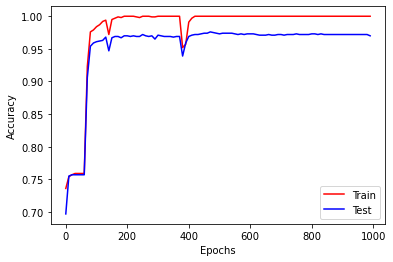

    Epoch  Acc_train  Acc_test  test_loss  train_loss
0     0.0      0.736     0.697      0.680       0.678
1    10.0      0.754     0.755      0.548       0.550
2    20.0      0.757     0.757      0.400       0.404
3    30.0      0.759     0.757      0.308       0.321
4    40.0      0.759     0.757      0.300       0.286
..    ...        ...       ...        ...         ...
95  950.0      1.000     0.972      1.839       0.001
96  960.0      1.000     0.972      1.486       0.001
97  970.0      1.000     0.972      1.758       0.001
98  980.0      1.000     0.972      1.174       0.001
99  990.0      1.000     0.970      1.576       0.001

[100 rows x 5 columns]


In [29]:
plt.plot(Results.Epoch,Results.Acc_train,'r',Results.Epoch,Results.Acc_test,'b')
plt.legend(['Train','Test'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
print(Results)

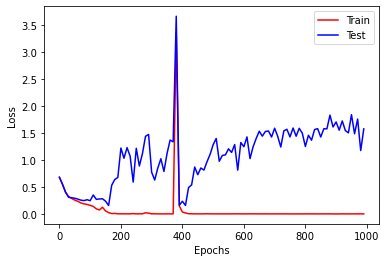

In [30]:
plt.plot(Results.Epoch,Results.train_loss,'r',Results.Epoch,Results.test_loss,'b')
plt.legend(['Train','Test'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [31]:
classes = ['No Voice', 'Voice']
y_pred = CNN(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

    No Voice       0.98      0.99      0.98      3993
       Voice       0.95      0.93      0.94      1282

    accuracy                           0.97      5275
   macro avg       0.97      0.96      0.96      5275
weighted avg       0.97      0.97      0.97      5275



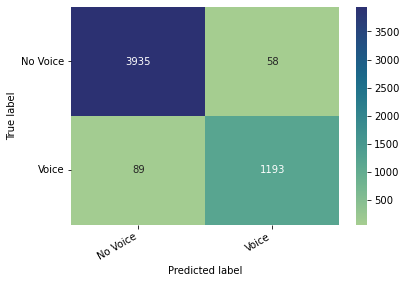

In [32]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
#hmap.color_palette("viridis", as_cmap=True)
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [33]:
y_pred = CNN(X_val)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_val = y_val.cpu()
print(classification_report(y_val, y_pred, target_names=classes))

              precision    recall  f1-score   support

    No Voice       0.98      0.99      0.99      3204
       Voice       0.97      0.94      0.95      1016

    accuracy                           0.98      4220
   macro avg       0.97      0.96      0.97      4220
weighted avg       0.98      0.98      0.98      4220



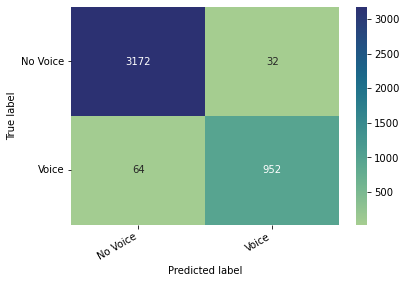

In [34]:
cm = confusion_matrix(y_val, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [35]:
#Shutting down the notebook

%%javascript
Jupyter.notebook.session.delete();

UsageError: Line magic function `%%javascript` not found.
